# How much should properties be worth in Milwaukee, Wisconsin? (Part I)

## Goals
The famous statistician George E.P. Box once stated:

$$
\textbf{"All models are wrong, but some models are useful."}
$$

Our world behaves according to so many variables which are out of our control, that expecting a simple model to *perfectly* explain these nuances is impossible. However, we can try to mitigate this issue by improving our understanding on the errors our models are producing. This allows us to update the model accordingly and be able to enhance its usefulness.

The main goal is of this case is to learn how to conduct a proper analysis of the errors (residuals) of linear regression models and how to use this analysis to make improvements in the model. You will see again how variable transformations and a study of outliers in the residuals can help with this task.

In [ ]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Introduction

**Business Context.** Real estate markets can sometimes be irrational, and buying a house can certainly be an emotional and highly psychological process. For example, the asking price can [“anchor”](https://en.wikipedia.org/wiki/Anchoring) the negotiations, and it can be very hard as a buyer to “forget” that initial number.

You are a property developer who frequently buys properties. It would be very useful to get a fair estimate of the price of a property before seeing the asking price, based on features like its size and location. Besides making you a more informed buyer, having a pricing model could have multiple uses, such as automatically detecting under-priced properties that come on the market, or estimating the value added to a property if it was extended, divided into apartments, or converted into offices.

**Business Problem.** Your task is to **build a model to predict property prices in the city of Milwaukee, Wisconsin**.

**Analytical Context.** The dataset consists of property sales (commercial and residential) in Milwaukee, Wisconsin from 2002 to 2018. Linear regression is a simple idea: At the end of the day, we are just fitting a line through data. But its simplicity is also its strength: coefficients are easily interpretable and it is straightforward to understand the underlying model. However, many things can go wrong during the process of fitting a linear model.

The case is structured as follows: you will 1) explore the data to pick up on some initial patterns; 2) analyze **residuals**, the difference between the actual values and their estimates, to diagnose an initial model; 3) perform variable transformations to partially deal with problems; and finally 4) look at how to deal with outliers to improve the model further.

## Data exploration

Let's start by taking a look at the available features:

1. **PropType**: the property category (“Commercial”, “Residential”, “Lg Apartment”, “Vacant Land”, or “Condominium”)
2. **Taxkey**: a unique identifier for the property
3. **Address**: the street address of the property
4. **CondoProject**: for condominiums, the name of the project
5. **District**: integer between 1 and 15 identifying the city district
6. **Nbhd**: integer identifying one of 591 neighborhoods
7. **Style**: information about the building architectural style, commerical use or type of building
8. **Extwall**: type of exterior wall (e.g. “Brick”)
9. **Stories**: number of stories
10. **Year_Built**: the year the building was built
11. **Nr_of_rms**: number of rooms
12. **Fin_sqft**: finished square feet
13. **Units**: number of units (e.g. apartments) in the building
14. **Bdrms**: number of bedrooms
15. **Fbath**: number of full bathrooms
16. **Hbath**: number of half bathrooms
17. **Lotsize**: size of the lot in square feet
18. **Sale_date**: the date of the sale in YYYY-MM-DD format
19. **Sale_price**: sale price in US dollars

In [3]:
data = pd.read_csv("2002-2018-property-sales-data.csv",
    dtype = { # indicate categorical variables
        "PropType": "category",
        "District": "category",
        "Extwall": "category",
        "Nbhd": "category",
        "Style": "category",
    },
    parse_dates=["Sale_date"], # the Sale_date column is parsed as a date
)
data.head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
0,Commercial,3230461110,2628 N 6TH ST,NaN,6,6258,Commercial Exempt,NaN,2.0,1880,0,1840,1,0,0,0,12750,2002-01-01,15900
1,Commercial,3590192000,1363 N PROSPECT AV,NaN,3,6262,Mansions With Commercial Usage,NaN,2.0,1876,0,6377,1,0,0,0,11840,2002-01-01,850000
2,Commercial,4161194000,617 S 94TH ST,NaN,10,6272,Service Building,NaN,1.0,1954,0,5022,1,0,0,0,9700,2002-01-01,119000
3,Commercial,1719836000,3624 W SILVER SPRING DR,NaN,1,6218,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1955,0,6420,1,0,0,0,8792,2002-01-01,210000
4,Commercial,3480290000,3830 W LISBON AV,NaN,15,6254,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1909,0,5956,1,0,0,0,4840,2002-01-01,48500


In [4]:
data.shape
data.isnull().sum()

PropType            3
Taxkey              0
Address             0
CondoProject    27867
District            0
Nbhd                0
Style               6
Extwall          9899
Stories             0
Year_Built          0
Nr_of_rms           0
Fin_sqft            0
Units               0
Bdrms               0
Fbath               0
Hbath               0
Lotsize             0
Sale_date           0
Sale_price          0
dtype: int64

Sometimes missing numbers are entered as zeros, which can mess up the analysis (see `Lotsize` below as an example). 
Before proceeding, we will remove rows with zeros in `Year_Built`, `Fin_sqft`, `Lotsize`, and `Sale_price`, as these are the numerical variables where erroneous zero values can skew the distribution:

Text(0, 0.5, 'count')

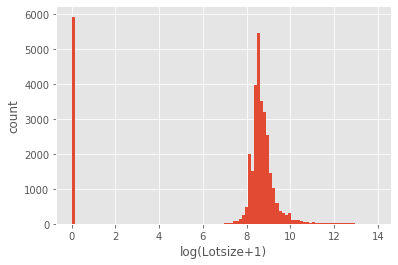

In [5]:
plt.hist(np.log(data["Lotsize"]+1), bins=100)
plt.xlabel("log(Lotsize+1)")
plt.ylabel("count")

For the sake of removing potential confounding factors from consideration, we will focus on residential properties only (commercial properties are subject to all sorts of economic and market forces that residential properties are not):

In [6]:
def remove_unused_categories(data):
    """ The `remove_unused_categories` method in pandas
        removes categories from a Series if there are no
        elements of that category.
        
        This function is a convenience function that removes
        unused categories for all categorical columns
        of a data frame.
        
        The reason this is useful is that when we
        fit a linear regression, `statsmodels` will
        create a coefficient for every category in a column,
        and so unused categories pollute the results.
    """
    for cname in data:
        col = data[cname]
        if pd.api.types.is_categorical_dtype(col):
            data[cname] = col.cat.remove_unused_categories()
    return data

clean = np.where(
    (data["Sale_price"] > 0) & 
    (data["Year_Built"] > 1800) &
    (data["Fin_sqft"] > 0) & # must have non-zero finished square feet
    (data["Lotsize"] > 0)  & # must have non-zero lot size
    (data["PropType"] == "Residential")
    )
data_clean = data.iloc[clean].copy()
remove_unused_categories(data_clean).head()

,PropType,Taxkey,Address,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
10,Residential,3080013000,3033 N 35TH ST,NaN,7,2960,AP 1,Frame,2.0,1913,0,3476,4,9,1,0,5040,2002-02-01,42000
51,Residential,3190434000,1908 E WEBSTER PL,NaN,3,3170,Rm or Rooming House,Frame,2.0,1897,0,1992,4,2,2,0,2880,2002-05-01,145000
67,Residential,3891722000,812 N 25TH ST,NaN,4,3040,Rm or Rooming House,Frame,2.0,1907,0,2339,6,0,1,0,3185,2002-06-01,30000
116,Residential,3880628000,959 N 34TH ST,NaN,4,2300,AP 1,Frame,2.0,1890,0,2329,4,4,1,0,5781,2002-10-01,66500
134,Residential,3880406000,3209 W WELLS ST,NaN,4,2300,Mansion,Stone,2.5,1891,0,7450,2,7,6,0,15600,2002-11-01,150500


In [7]:
data_clean.shape

(24450, 19)

### Exercise 1:

#### 1.1

Write code to visualize the relationship between the logarithm of the sale price per square foot (`Fin_sqft`) and the following variables:
 
1. the number of units (C)
2. the year the building was built 
3. the city district (C)
4. the logarithm of the finished square footage
5. the number of bedrooms (C)
6. the sale date

For categorical variables, it can be helpful to use **violin plots**, which first separates the data by category and then shows the distribution of the $y$ variable as a smooth histogram for each category. 

**Hint:** You can use the seaborn function ```sns.violinplot(x,y,data)```. For this exercise, draw violin plots for the variables with a (C) as shown above.

**Answer.**

----------

#### 1.2

What can you conclude from these exploratory plots? Select all that apply.

(a) Properties built in the last ten years tend to be more valuable (per square foot)

(b) Dividing a single-unit property into smaller units would tend to make it more valuable

(c) Many of the most valuable properties are in districts 3 and 14

(d) Having more bedrooms makes a property less valuable

**Answer.**

----------

### Exercise 2:

Provide the code to fit a multiple linear regression of the sale price against the district, number of units, and finished square footage. Which districts does the model recognize as having the most valuable properties? Are all the coefficients significant? If not, how should we interpret the coefficients with high $p$-value?

**Answer.**

----------

## Inspecting residuals to diagnose a fitted model

Linear regression is conceptually simple — after all, we are just fitting a line through our data — but a lot can go wrong. **Residual analysis** is an important tool for diagnosing many problems that can affect a linear regression.
The “residuals” are the difference between the observations $y$ and the corresponding fitted values $\hat{y}$;
visually it is the distance between the fitted line and the data points.

Residual analysis allows us to test some of the theoretical assumptions that underpin linear regression. The short version is that linear regression works best when the residuals are identically [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution). You may have come across statements before claiming that “linear regression assumes the data are normally distributed", which is not entirely correct. Linear regression can still be a useful and powerful (and theoretically justified!) tool even if the data deviates from this assumption. That said, a distribution with fat tails is a particular problem for linear regression, because points “in the tails” that are far away from their fitted values can disproportionately affect the fitted coefficients and the predictions. Even a single such point, which could for example be caused by a misplaced decimal point when the raw data was manually entered into a spreadsheet by a distracted employee, can wreak havoc on a model. Such a data point is said to have high **leverage** on the model.

### Exercise 3:

#### 3.1

Obtain the residuals by comparing observations against fitted values (`model_lin.fittedvalues`). Check that you recover the same values as those stored in `model_lin.resid`.

**Answer.**

----------

#### 3.2

Plot a histogram and a QQ plot of the residuals. What do you notice? 
    
**Hint:** To compare the residuals histogram to a normal distribution, use the ```density=True``` argument of ```plt.hist```, which puts the histogram on the same scale as the normal distribution. Then, add the code:
```
xx = np.linspace(model_lin.resid.min(), model_lin.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_lin.scale)),
    label="normal distribution")
```
to overlay the probability density function of the normal distribution.

In order visualize the outliers in the histogram, we can use the `rugplot()` function in the `seaborn` library. For the purpose of this exercise, define the outliers as those residuals which are more than four standard deviations away from zero.

**Answer.**

----------

We also create the QQ plot of the residuals, which shows nonlinearity and is another strong warning sign:

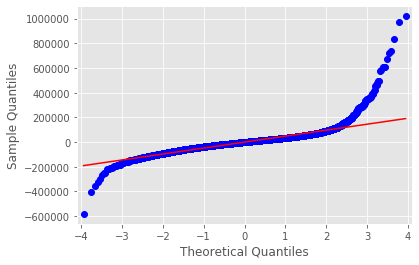

In [12]:
sm.qqplot(model_lin.resid, line="s");

Another troublesome situation that can be detected using residual analysis is **heteroscedasticity**, which means that the residuals have small variance for in some subsets of the data, and high variance in others. We saw this exactly early on in the previous case, with the data points "fanning out" around the line of best fit, and determined that this would cause problems. The opposite of heteroscedasticity is **homoscedasticity**, which is what we want to see in the data, and means that the residuals have similar variance across all subsets of the data.

### Exercise 4:

#### 4.1

Suppose that we are given data from a pair houses in Milwaukee, say ```house1``` and ```house2```. We used our model to obtain a recommended sale price for  each house. The price returned for ```house1``` was $\$60,000$ and for ```house2``` was $\$7,000,000$. We know that the final selling price of each house will be different, as it depends on several other factors not included in the model. In the end, the actual selling price of each house will lie in some interval

$$
\begin{aligned}
 \$60,000-\verb*std1*&\leq \verb*house1* \leq \$60,000+\verb*std1*,\\
&\\
\$7,000,000-\verb*std2* &\leq \verb*house2*\leq \$7,000,000+\verb*std2*.
\end{aligned}
$$

Which deviation would you expect to be larger, ```std1``` or ```std2```?

**Answer.**

----------

#### 4.2
Verify your findings from Exercise 4.1 by drawing a scatterplot of the residuals against the square footage. Are the residuals homoscedastic or heteroscedastic?

**Hint:** In order to see changes in the variance a little better, you may also subdivide the data in `Fin_sqft` into four bins and draw violin plots.

**Answer.**

----------

As a side note, heteroscedasticity is easy to show, but homoscedasticity is hard to demonstrate, because we have to show that *none* of the variables exhibit heteroscedasticity. In general, use your *intuition* to hunt for heteroscedasticity; here, it was perhaps foreseeable that small (and hence cheap) houses would have a more predictable sales price than large (expensive) houses.

## Transforming variables to mitigate residuals issues

Now that we have seen that the residuals are problematic, we need to figure out what to do about them. One possible solution is to borrow the technique we learned in a previous case – taking a transformation of the response variable. Let's try making the response variable the logarithm of `Sale_price`. It is a natural assumption that the sale price should be proportional to the square footage of the property. Therefore, we will also take the logarithm of the square footage as a predictor variable in this model:

In [14]:
model_log = smf.ols(formula = "np.log(Sale_price) ~ District + Units"
                           "+ np.log(Fin_sqft)", 
                 data = data_clean).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(Sale_price)   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     2283.
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:11:49   Log-Likelihood:                -10020.
No. Observations:               24450   AIC:                         2.007e+04
Df Residuals:                   24433   BIC:                         2.021e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.2346      0.057     91.435      0.000       5.122       5.347
District[T.10]       0.6272      0.013     46.510      0.000       0.601       0.654
District[T.11]       0.8221      0.013     63.362      0.000       0.797       0.847
District[T.12]      -0.0038      0.021     -0.183      0.854      -0.045       0.037
District[T.13]       0.8019      0.013     59.694      0.000       0.776       0.828
District[T.14]       0.8701      0.013     64.855      0.000       0.844       0.896
District[T.15]      -0.4857      0.020    -24.462      0.000      -0.525      -0.447
District[T.2]        0.3132      0.015     20.827      0.000       0.284       0.343
District[T.3]        1.0223      0.015     66.953      0.000       0.992       1.052
District[T.4]       -0.1997      0.031     -6.464      0.000      -0.260      -0.139
District[T.5]        0.6896      0.013     53.242      0.000       0.664       0.715
District[T.6]       -0.1841      0.018    -10.103      0.000      -0.220      -0.148
District[T.7]       -0.0692      0.016     -4.272      0.000      -0.101      -0.037
District[T.8]        0.1567      0.017      9.050      0.000       0.123       0.191
District[T.9]        0.5799      0.016     36.764      0.000       0.549       0.611
Units               -0.3523      0.006    -55.450      0.000      -0.365      -0.340
np.log(Fin_sqft)     0.8687      0.008    104.173      0.000       0.852       0.885
==============================================================================
Omnibus:                     8475.447   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120216.866
Skew:                          -1.272   Prob(JB):                         0.00
Kurtosis:                      13.561   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Exercise 5:

#### 5.1

Plot a histogram of the residuals, similar to what we did in Exercise 3. Did the log transformation fix the skewness and outlier issues that we noticed earlier?

**Hint:** What changes in [Skewness](https://en.wikipedia.org/wiki/Skewness) and [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis)  do you see in the new model? 

**Answer.**

----------

#### 5.2

Did the heteroscedasticity issue improve from Exercise 4?

**Answer.**

----------

### Exercise 6:

#### 6.1

How do we interpret the `Units` coefficient?

**Answer.** All else being equal, an additional unit decreases the log-price of the property by 0.35, which corresponds to a slightly less than 30% reduction in price (this is calculated as $1-e^{-0.35}$).

#### 6.2

What story does the `np.log(Fin_sqft)` coefficient tell us in this model?

(a) The price of a property is proportional to its square footage

(b) The price of a property goes down with square footage

(c) The price of a property goes up logarithmically with its square footage

(d) The price of a property goes up exponentially with its square footage

(e) The price of a property goes up with square footage, but there are diminishing returns

**Answer.**

----------

## Dealing with outliers

Our analysis of residuals shows a number of outliers. As mentioned above, low outliers are not entirely unexpected; e.g. when people sell a property to friends or relatives, or if the property is in disrepair, the sale price could be significantly lower than expected by the model. Nonetheless, outliers can destabilize a model and significantly reduce their predictive ability despite only representing a fringe subset of the overall data.

### Question:

What should an analyst do with outliers?

It is tempting to simply remove data points with large residuals; however, this viewpoint suffers from hindsight bias. Outliers with high residuals cannot be determined before the model is created, which means that they cannot be removed in advance.

Rather, the starting point should always be to inspect the initial raw data for any data points with unusually small or large values for certain features, and understand why they are different. If there is something clearly wrong with those data (like a misplaced decimal point), or if the reason for these small or large values can be effectively explained via an external factor that is not captured by the data itself, then this justifies removing them. Otherwise, it is best to keep these data points in mind throughout the modeling process, and deal with them during the modeling process itself.

### Exercise 7:

Print the characteristics of the property with the greatest absolute residual (i.e. the worst outlier in the dataset). For this property, what is the fitted (predicted) and actual sale price?

Find all other sales of the same property in the dataset. Can you see an explanation for these extreme outliers?

**Answer:**

----------

The scatter plot below shows the residuals vs. the sale price for all properties in the data. The cluster in the bottom left corner shows properties that sold at a much lower price than expected by the model, which can be explained as transactions below market rate between friends or relatives. This would justify removing all transactions below about $2,000 from the dataset before re-running the analysis:

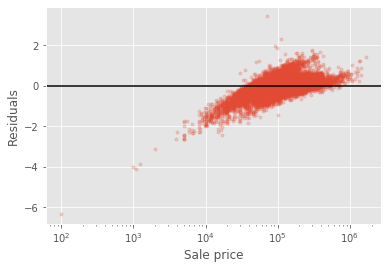

In [21]:
plt.semilogx(data_clean["Sale_price"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Sale price")
plt.axhline(0, color="black")

We can quantify the effect of these outliers by removing them and re-running the regression, and seeing how the fitted coefficients change.

### Exercise 8:

#### 8.1

Re-run the same model one a reduced dataset which removes all outliers with absolute residuals greater than 1.5.

1. What percentage of the data is removed?
2. What is the value of the fitted `Units` coefficient before and after removing outliers?
3. Is the difference significant?
4. What coefficients move by more than two standard errors after removing outliers?

**Answer.**

----------

#### 8.2

Check whether particularly small or large properties also tend to result in outliers.

**Answer.** 

----------

## Conclusions

We used linear regression to predict property sale price in Milwaukee, Wisconsin, and illustrated some potential issues with linear regression. When some of the assumptions of linear regression are severly violated, like normality of the residuals and homoescedasticity, the fitted model can be destabilized. As an example, we saw how a small number of outliers can shift a fitted coefficient by several standard errors.

## Takeaways

In this case we have learned:
    
1. How to recognize heteroscedasticity in the residuals and why it is important to treat it. 
2. How transforming the outcome variable can be helpful to reduce skewness and alleviate some of the heteroscedasticity present in the residuals.
3. How to properly treat outliers in the residuals. We recognized that it is always better to understand the meaning behind some of the outliers in order to safely discard them from our models. In this case, a logarithmic transformation of the sale price alleviated many of the issues in the model. However, other datasets may invite different transformations. You should combine intuition and experimentation to find the right transformation to use.
5. How to conduct residual analysis when using linear regression in your projects. As we have seen, these will help you to improve not only the quality of your models, but also your intuition and expertise when conducting future data analyses at work.